### Imports

In [57]:
import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import __version__ as sklearn_version
from sklearn.model_selection import cross_validate

### Load Model

In [58]:
expected_model_version = '1.0'
model_path = '../models/hospital_RR_model.pkl'
if os.path.exists(model_path):
    with open(model_path, 'rb') as f:
        model = pickle.load(f)
    if model.version != expected_model_version:
        print("Expected model version doesn't match version loaded")
    if model.sklearn_version != sklearn_version:
        print("Warning: model created under different sklearn version")
else:
    print("Expected model not found")

### Load Data

In [59]:
#Data table with hipass of 200 inpatient cases per hospital used to generate fnal model
hosp_data = pd.read_csv('../data/main_df_post2_200.csv')

In [60]:
hosp_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2473 entries, 0 to 2472
Data columns (total 37 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ReadmissionRate       2473 non-null   float64
 1   Facility_ID           2473 non-null   object 
 2   City                  2473 non-null   object 
 3   State                 2473 non-null   object 
 4   County                2473 non-null   object 
 5   Total_Admissions      2473 non-null   int64  
 6   HAI_1_SIR             1949 non-null   float64
 7   HAI_2_SIR             2133 non-null   float64
 8   HAI_5_SIR             1674 non-null   float64
 9   HAI_6_SIR             2320 non-null   float64
 10  PSI_3                 2445 non-null   float64
 11  PSI_6                 2445 non-null   float64
 12  PSI_8                 2445 non-null   float64
 13  PSI_9                 2436 non-null   float64
 14  PSI_10                2335 non-null   float64
 15  PSI_11               

In [61]:
#Separating out our target/client hospital
targ_hosp = hosp_data[hosp_data.Facility_ID == '310041']

In [62]:
targ_hosp.T

,1410
ReadmissionRate,16.8
Facility_ID,310041
City,TOMS RIVER
State,NJ
County,Ocean
Total_Admissions,2877
HAI_1_SIR,0.732
HAI_2_SIR,0.376
HAI_5_SIR,0.376
HAI_6_SIR,0.415


In [63]:
targ_hosp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1 entries, 1410 to 1410
Data columns (total 37 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ReadmissionRate       1 non-null      float64
 1   Facility_ID           1 non-null      object 
 2   City                  1 non-null      object 
 3   State                 1 non-null      object 
 4   County                1 non-null      object 
 5   Total_Admissions      1 non-null      int64  
 6   HAI_1_SIR             1 non-null      float64
 7   HAI_2_SIR             1 non-null      float64
 8   HAI_5_SIR             1 non-null      float64
 9   HAI_6_SIR             1 non-null      float64
 10  PSI_3                 1 non-null      float64
 11  PSI_6                 1 non-null      float64
 12  PSI_8                 1 non-null      float64
 13  PSI_9                 1 non-null      float64
 14  PSI_10                1 non-null      float64
 15  PSI_11               

### Refit Model on All Available Data (Excluding Target Hospital)

We want to train a model to predict our client hospital's readmission rate based on data from all of the other hospitals.

In [64]:
X = hosp_data.loc[hosp_data.Facility_ID != "310041", model.X_columns]
y = hosp_data.loc[hosp_data.Facility_ID != "310041", 'ReadmissionRate']

In [65]:
len(X), len(y)

(2472, 2472)

In [66]:
model.fit(X, y)

Pipeline(steps=[('simpleimputer', SimpleImputer()), ('standardscaler', None),
                ('histgradientboostingregressor',
                 HistGradientBoostingRegressor(learning_rate=0.06, max_depth=5,
                                               max_iter=40, random_state=47))])

#### Mean Absolute Error (MAE)

In [67]:
cv_results = cross_validate(model, X, y, scoring='neg_mean_absolute_error', cv=5)

In [68]:
cv_results['test_score']

array([-0.5592862 , -0.60410999, -0.60575533, -0.54108386, -0.53348415])

In [69]:
mae_mean, mae_std = np.mean(-1 * cv_results['test_score']), np.std(-1 * cv_results['test_score'])
mae_mean, mae_std

(0.5687439081447355, 0.030719317406488676)

#### Root Mean Squared Error (RMSE)

In [70]:
cv_results2 = cross_validate(model, X, y, scoring='neg_root_mean_squared_error', cv=5)

In [71]:
cv_results2['test_score']

array([-0.72870123, -0.78306256, -0.7940349 , -0.72373802, -0.66748773])

In [72]:
rmse_mean, rmse_std = np.mean(-1 * cv_results2['test_score']), np.std(-1 * cv_results2['test_score'])
rmse_mean, rmse_std

(0.7394048893187808, 0.04565638248405665)

### Calculate Expected Client Hospital Readmission Rate From the Model

In [73]:
X_client = hosp_data.loc[hosp_data.Facility_ID == "310041", model.X_columns]
y_client = hosp_data.loc[hosp_data.Facility_ID == "310041", 'ReadmissionRate']

In [74]:
client_pred = model.predict(X_client).item()

In [75]:
y_client = y_client.values.item()

In [76]:
print(f'Client modelled Readmission Rate is {client_pred:.2f}, actual Readmission Rate is {y_client:.2f}.')
print(f'Even with the expected root mean squared error of {rmse_mean:.2f}, this suggests there is room for improvement in next cycle just by chance.')

Client modelled Readmission Rate is 15.45, actual Readmission Rate is 16.80.
Even with the expected root mean squared error of 0.74, this suggests there is room for improvement in next cycle just by chance.


### Client Hospital in Context

Features that came up as paritcularly important in Random Forest Model (performed nearly as well as the HGB model):
* HIPKNEE_TA_PROP (-): Proportion of initial admissions with a (non-mutually exclusive) reason as hip/knee replacement surgery
* AMI_TA_PROP (-): Proportion of initial admissions with a (non-mutually exclusive) reason as acute myocardial infarction
* PSI_11 (+): Postoperative respiratory failure score (higher = relatively more frequent than expected for a similar hospital according to CMS)

In [77]:
#Looking at client hospital in context of sample population for these features
def plot_compare(feat_name, description, State=None, figsize=(10, 5)):
    """Graphically compare distributions of features.
    
    Plot histogram of values for all resorts and reference line to mark
    Client Hospital's position.
    
    Arguments:
    feat_name - the feature column name in the data
    description - text description of the feature
    state - select a specific state (None for all states)
    figsize - (optional) figure size
    """
    
    plt.subplots(figsize=figsize)
    # quirk that hist sometimes objects to NaNs, sometimes doesn't
    # filtering only for finite values tidies this up
    if State is None:
        hosp_x = hosp_data[feat_name]
    else:
        hosp_x = hosp_data.loc[hosp_data.State == State, feat_name]
    hosp_x = hosp_x[np.isfinite(hosp_x)]
    plt.hist(hosp_x, bins=30)
    plt.axvline(x=targ_hosp[feat_name].values, c='r', ls='--', alpha=0.8, label='Client Hospital')
    plt.xlabel(description)
    plt.ylabel('frequency')
    plt.title(description + ' distribution for comparable hospitals in data set')
    plt.legend()

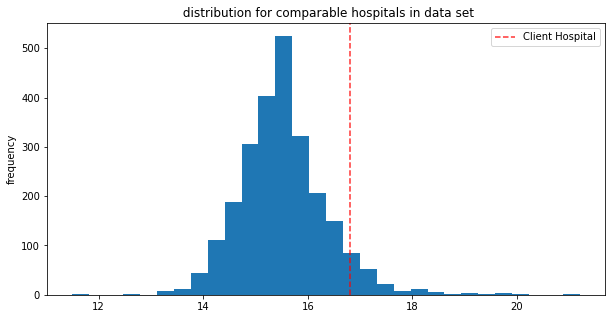

In [78]:
plot_compare('ReadmissionRate', '')

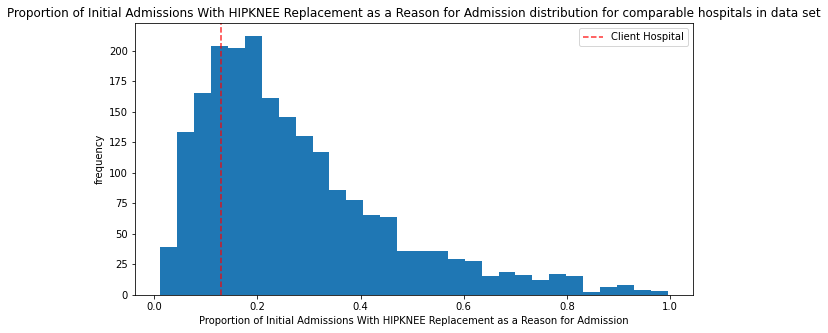

In [79]:
plot_compare('HIPKNEE_TA_PROP', 'Proportion of Initial Admissions With HIPKNEE Replacement as a Reason for Admission')

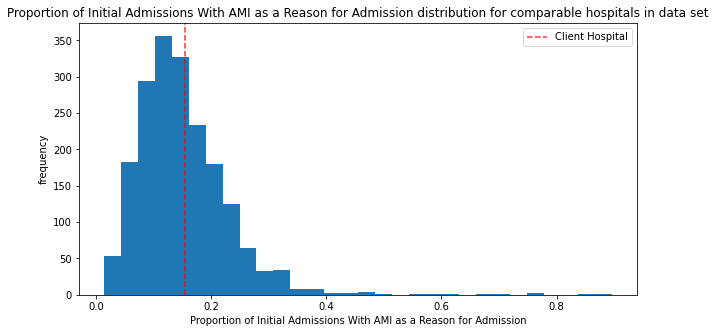

In [80]:
plot_compare('AMI_TA_PROP', 'Proportion of Initial Admissions With AMI as a Reason for Admission')

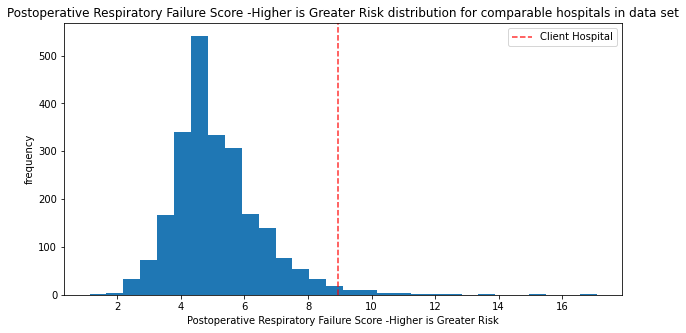

In [81]:
plot_compare('PSI_11', 'Postoperative Respiratory Failure Score -Higher is Greater Risk')

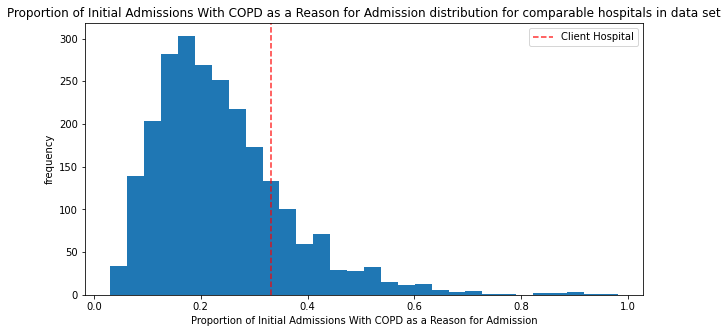

In [82]:
plot_compare('COPD_TA_PROP', 'Proportion of Initial Admissions With COPD as a Reason for Admission')

Perhaps most notably, our client hospital scored very poorly on normalized postoperative respiratory score (PSI-11) relative to the population. Also, our client hospital was toward the low end of the distribution for proportion of initial admissions with a (non-mutually exclusive) reason as hip/knee replacement surgery (HIP_KNEE_TA_PROP).

### Modeling Scenarios

It would be of interest to know if improvement on normalized postoperative respiratory score (PSI-11), to the population median, would improve the best model-based Readmission Rate for our client hospital. There is the possibility that increased vigilance, training and new protocols could lead to improvement in this metric. Also of interest is knowing whether an increase in the proportion of initial admissions for hip/knee replacement surgery would yield an improved Readmission Rate. 

In [83]:
#In this function, we copy the Target Hospital data into a new data frame
#And then for each feature, and each of its deltas (changes from the original),
#we create the modified scenario dataframe (th2) and make a readmission rate prediction
#for it. The difference between the scenario's prediction and the current
#prediction is then calculated and returned.
def predict_increase(features, deltas):
    """Increase in modelled readmission rate by applying delta to feature.
    
    Arguments:
    features - list, names of the features in the hosp_data dataframe to change
    deltas - list, the amounts by which to increase the values of the features
    
    Outputs:
    Amount of increase in the predicted readmission rate
    
    """
    
    th2 = X_client.copy()
    for f, d in zip(features, deltas):
        th2[features] += deltas
    return model.predict(th2).item() - model.predict(X_client).item()

#### For Impactful Features Where Target Hospital 'Underperforms', Calculate Delta to Get to Hospital Population Means

In [84]:
desired_delta_1 = hosp_data["PSI_11"].median() - targ_hosp.iloc[0,15]
desired_delta_1

-4.091966999999999

In [85]:
hosp_data["PSI_11"].median(), targ_hosp.iloc[0,15]

(4.8543590000000005, 8.946326)

In [86]:
desired_delta_2 = hosp_data["HIPKNEE_TA_PROP"].median() - targ_hosp.iloc[0,25]
desired_delta_2

0.09939231231925921

In [87]:
hosp_data["HIPKNEE_TA_PROP"].median(), targ_hosp.iloc[0,25]

(0.2279984993196068, 0.1286061870003476)

### Scenario: Reducing Postoperative Respiratory Failure Score to that of Hospital Population Median and Increasing the Proportion of Inpatient Hip-Knee Replacement Cases to Hospital Population Median

In [88]:
RR_increase = predict_increase(['HIPKNEE_TA_PROP', 'PSI_11'], [desired_delta_2, desired_delta_1])
RR_increase

-0.3161290053680972

In [89]:
print(f'This scenario reduces model-predicted Readmission Rate by {RR_increase:.2f}%')

This scenario reduces model-predicted Readmission Rate by -0.32%


## Business Case Conclusions

#### Not making any changes in hospital processes, procedures, or general business practice may still result in the 1% decrease in RR required to avoid CMS penalty, simply due to regression toward mean expectation. 

Rationale: The model predicts an RR of 15.5% (+-.7%) for CMC, while the actual RR last year was 16.8%. Considering the mean difference and margin of error, such a decrease is well within the range of probable outcomes. 

#### If CMC is inclined to make several rapid, low investment changes that may have an impact in RR, a combination of modestly expanding capacity for hip-knee replacement surgeries and focusing on improving existing protocols for detection and treatment of post-operative respiratory failure is worth exploring.
 
 Rationale: The proportion of hip-knee replacements in the case mix has a negative correlation with RR. Additionally, though not implying a causative effect on RR, this feature was also the most important of all in model generation. CMC is currently on the low end of the hospital sample distribution in terms of hip-knee replacements in the case mix. In contrast, CMC is at the extreme high end of the distribution for postoperative respiratory failure rate, a feature with a positive correlation with RR. As with hip-knee replacement, post-operative respiratory failure rate was also one of the most important features in model generation (which, again, does not imply causation of RR). 
To this end, a scenario in which both of the aforementioned features are brought to hospital sample median level for CMC yields a prediction of RR reduction of 0.32%, which is 32% of the goal reduction of 1%. For hip-knee replacement rate, getting to the sample median would mean an increase from 13% of total inpatient cases to 27% of total inpatient cases.  For postoperative respiratory failure rate, getting to the sample median would mean a decrease from 9% to 5%. Though these reductions in full may be infeasible within a year, modest movement in the right direction for each, coupled to regression toward mean expectation (see Summary Point #1), may be sufficient to achieve the goal reduction. 

Though potentially not possible to modify in an ethical way, and thus not included in this modeling scenario, it is worth noting that CMC also has a case rate involving COPD at admission in the upper-third of the sample distribution. As with postoperative respiratory failure rate, this is a respiratory feature that has a positive correlation with RR (and, likewise, was one of the most important features in model generation). The relatively high postoperative failure rate for CMC may, in fact, be closely related to the well higher-than-average proportion of patients who are admitted as inpatients at CMC already with breathing problems (COPD). Therefore, extra vigilance for patients in the post-operative period who presented with COPD at admission may make attempts to globally reduce postoperative respiratory failure rate more effective. 


## Future Directions

Though the feature-rich machine learning model is substantially more accurate in prediction of hospital readmission rates (RR) than simple methods, such as prediction with the sample mean, such prediction remains a challenging task. One of the main reasons for this is that RRs are relatively tightly clustered within a few percentage point range. And, as we saw with prediction of the client hospital RR, margin of error for a given hospital in a given year can be a substantial proportion of this overall distribution. 
With the above said, there are several clear avenues to pursue in trying to improve model prediction of RR accuracy:
1)  Conduct non-supervised analyses, such as Cluster Analysis, to initially classify hospitals in the overall sample by properties such as size, private vs public status, network affiliation status, case volume/mix, and demographic/socioeconomic context in which the hospital operates. Each of the resultant clusters can then be modeled separately, and prediction accuracy can be compared to that of the full, highly heterogenous sample (as was conducted presently).

2) Seek and obtain better data on facility resourcing at the hospital level. One of the main data holes in the present analysis is that hospital resourcing had to be measured indirectly. This was done several ways, for example by creating features that considered county-level population, hospital density and facility case load together to infer aspects of “ facility burden”. Much more optimal would be to have raw data, and be able to compute derivative features, for hospital-level resources directly. The raw data would include numbers of doctors and nurses, number of operating rooms, number of ICU beds, and all of the previous in relation to number of patient numbers.

3)  Seek and obtain patient-level data at the hospital level. Additionally, though I created patient features involving socioeconomics (such as median income) and demographic features (such as median age) for the present study, these features were generated per hospital with county-level data. Much more ideal would be to obtain (anonymized, of course) hospital-level patient data from which to generate features characterizing patients at each hospital. This could perhaps facilitate “normalization” of hospital level outcomes metrics by baseline patient characteristics in a manner that would lead to improved prediction quality. 
